In [1]:
!pip install h5py
!pip install matplotlib==3.4.0
!pip install e2cnn
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 98.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 KB 21.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 20.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

In [4]:
import h5py
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import random
from e2cnn import gspaces
from e2cnn import nn
from torchsummary import summary
from pytorch_lightning import LightningModule
import torch
from torch.nn import functional as F
from typing import Optional
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from typing import Tuple
from tqdm.auto import tqdm
import torchmetrics
import torch.optim as optim

In [5]:
import matplotlib
print(matplotlib.__version__)

3.2.2


## Wczytanie danych

In [6]:
filename_train_x='/content/drive/MyDrive/Dane_projekt_UR/camelyonpatch_level_2_split_train_x.h5'
filename_train_y='/content/drive/MyDrive/Dane_projekt_UR/camelyonpatch_level_2_split_train_y.h5'
filename_test_x='/content/drive/MyDrive/Dane_projekt_UR/camelyonpatch_level_2_split_test_x.h5'
filename_test_y='/content/drive/MyDrive/Dane_projekt_UR/camelyonpatch_level_2_split_test_y.h5'

train_x = {}
train_y = {}
test_x = {}
test_y = {}

import torchvision

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

with h5py.File(filename_train_y, "r") as f:
    for key in f.keys():
        ds_arr = f[key][()] 
        ds_arr.shape = (ds_arr.shape[0])
        train_y[key] = ds_arr[:1000] 


with h5py.File(filename_train_x, "r") as f:
    for key in f.keys():
        ds_arr = f[key][()] 
        train_x[key] = ds_arr[:1000] 

train_data = []
for i in range(0, 1000):
   train_data.append([transform(train_x['x'][i]), train_y['y'][i]])
   

with h5py.File(filename_test_y, "r") as f:
    for key in f.keys():
        ds_arr = f[key][()]  
        ds_arr.shape = (ds_arr.shape[0])
        test_y[key] = ds_arr[:1000]

with h5py.File(filename_test_x, "r") as f:
    for key in f.keys():
        ds_arr = f[key][()] 
        test_x[key] = ds_arr[:1000]

test_data = []
for i in range(0, 1000):
   test_data.append([transform(test_x['x'][i]), test_y['y'][i]])

In [7]:
del train_x
del train_y
del test_x
del test_y

## Koder wykorzystujący ekwiwariantne sieci konwolucyjne

Zbadano jakość klasyfikacji wykorzystując koder zbudowany z wykorzystaniem ekwiwariantnych sieci konwolucyjnych. Zbadano czy większy wpływ na dokładność klasyfikacji ma to czy koder jest dobrze dopasowany do próbek czy to, że jest on uczony na większej ilości danych. W tym celu najpierw przeprowadzono badania, gdzie koder był trenowany na 10 obrazach a następnie model do klasyfikacji uczono na całym zbiorze treningowym.  W drugim badaniu zarówno koder jak i model uczono na całym zbiorze treningowym.

In [8]:
class GCNNEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim: int, N: int):
        super(GCNNEncoder, self).__init__()

        self.r2_act = gspaces.Rot2dOnR2(N=N)
        in_type = nn.FieldType(self.r2_act, 3*[self.r2_act.trivial_repr])
        self.in_typ = in_type
        
        # convolution 1
        out_type = nn.FieldType(self.r2_act, 8*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=3, stride=2, padding=1),
            nn.ReLU(out_type)
        )
        # convolution 2
        in_type = self.block1.out_type
        out_type = nn.FieldType(self.r2_act, 16*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=3, stride=2, padding=1),
            nn.ReLU(out_type)
        )
       # convolution 3
        in_type = self.block2.out_type
        out_type = nn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=3, stride=2, padding=1),
            nn.ReLU(out_type)
        )
        # convolution 4
        in_type = self.block3.out_type
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=3, stride=2, padding=1),
            nn.ReLU(out_type)
        )
        # convolution 5
        in_type = self.block4.out_type
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=3, stride=2, padding=1),
            nn.ReLU(out_type)
        )

        self.pool = nn.PointwiseMaxPoolAntialiased(out_type, kernel_size=3)
        self.gpool = nn.GroupPooling(out_type)
        c = self.gpool.out_type.size
        self.fully_net = torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Linear(c, 128),
          torch.nn.ReLU(True),
          torch.nn.Linear(128, latent_dim),
        )
        
    def forward(self, img: torch.Tensor) -> torch.Tensor:
        x = nn.GeometricTensor(img, self.in_typ)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.pool(x)
        x = self.gpool(x)
        x = x.tensor
        x = self.fully_net(x.reshape(x.shape[0], -1))
        return x

In [9]:
class Autoencoder(LightningModule):

    def __init__(self, encoder: torch.nn.Module, decoder: torch.nn.Module):
        super().__init__()

        self._encoder = encoder
        self._decoder = decoder

    def forward(self, x):
        return self._encoder(x)

    def reconstruct(self, x):
        return self._decoder(z=self(x))

    def training_step(self, batch, batch_size):
        x, _ = batch
        xr = self.reconstruct(x)

        loss = F.mse_loss(input=xr, target=x)
        self.log("train/mse", loss.detach().item())
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [10]:
class CNNDecoder(torch.nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self._layers = torch.nn.Sequential(
            # MLP
            torch.nn.Linear(latent_dim, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 96 * 3 * 3),
            torch.nn.ReLU(True),
            # Reshape into image
            torch.nn.Unflatten(dim=1, unflattened_size=(96, 3, 3)),
            # Deconvolution
            torch.nn.ConvTranspose2d(96, 64, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, z):
        return self._layers(z)

In [11]:
class GCNNAutoencoder(Autoencoder):
    
    def __init__(self, latent_dim: int):
        super().__init__(
            encoder=GCNNEncoder(latent_dim=latent_dim, N=8),
            decoder=CNNDecoder(latent_dim=latent_dim),
        )
    

### **Badanie 1:** Koder uczony na 10 obrazach, model do klasyfikacji uczony na całym zbiorze

In [46]:
gcnn_ae = GCNNAutoencoder(latent_dim=64)
trainer = Trainer(
    accelerator="gpu",
    max_epochs=5000,
)

train_dl = DataLoader(train_data[:10], batch_size = 64, shuffle = True)
test_dl = DataLoader(test_data, batch_size = 128, shuffle = True)
trainer.fit(
    model=gcnn_ae,
    train_dataloaders=train_dl,
    
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type        | Params
-----------------------------------------
0 | _encoder | GCNNEncoder | 444 K 
1 | _decoder | CNNDecoder  | 199 K 
-----------------------------------------
644 K     Trainable params
0         Non-trainable params
644 K     Total params
2.578     Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5000` reached.


In [41]:
class ClassificationGCNNEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim: int, N: int):
        super().__init__()
        self.gce = gcnn_ae._encoder
        for param in self.gce.parameters():
          param.requires_grad = True;
        self.mlp=torch.nn.Sequential(
          torch.nn.ReLU(),
          torch.nn.Linear(64, 32),
          torch.nn.ReLU(),
          torch.nn.Linear(32, 1),
          torch.nn.Sigmoid()
        )
      

    def forward(self, img: torch.Tensor) -> torch.Tensor:
      x = self.gce(img)
      x = self.mlp(x)
      return x 

In [47]:
model = ClassificationGCNNEncoder(latent_dim=64, N=8)

loss_fc = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_dl = DataLoader(train_data, batch_size = 128, shuffle = True)

for epoch in range(10):  
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        labels = labels.to(torch.float)
        optimizer.zero_grad()

        preds = model(inputs)
        loss = loss_fc(preds.reshape(preds.shape[0]), labels)

        loss.backward()
        optimizer.step()

        accuracy = torchmetrics.Accuracy(task='binary')
        acc = accuracy(preds.reshape(preds.shape[0]), labels)

        # print statistics
        running_loss += loss
        running_acc += acc

    print(
         f"Epoch {epoch}: "
         f"train loss = {running_loss / 8:.3f} (acc: {running_acc /8:.3f}), "
        )


Epoch 0: train loss = 0.697 (acc: 0.525), 
Epoch 1: train loss = 0.677 (acc: 0.567), 
Epoch 2: train loss = 0.666 (acc: 0.609), 
Epoch 3: train loss = 0.645 (acc: 0.618), 
Epoch 4: train loss = 0.595 (acc: 0.696), 
Epoch 5: train loss = 0.523 (acc: 0.753), 
Epoch 6: train loss = 0.457 (acc: 0.805), 
Epoch 7: train loss = 0.375 (acc: 0.858), 
Epoch 8: train loss = 0.303 (acc: 0.893), 
Epoch 9: train loss = 0.235 (acc: 0.920), 


In [48]:
total = 0
acc = 0

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images)
        total += 1
        accuracy = torchmetrics.Accuracy(task='binary')
        acc += accuracy(outputs.reshape(outputs.shape[0]), labels)

print(f'Zbiór testowy: accuracy =  {100 * acc / total} %')

Zbiór testowy: accuracy =  70.25240325927734 %


### **Badanie 2:** Zarówno koder jak i model do klasyfikacji trenowane na całym zbiorze

In [49]:
gcnn_ae = GCNNAutoencoder(latent_dim=64)
trainer = Trainer(
    accelerator="gpu",
    max_epochs=5000,
)

train_dl = DataLoader(train_data, batch_size = 128, shuffle = True)
test_dl = DataLoader(test_data, batch_size = 128, shuffle = True)
trainer.fit(
    model=gcnn_ae,
    train_dataloaders=train_dl,
    
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type        | Params
-----------------------------------------
0 | _encoder | GCNNEncoder | 444 K 
1 | _decoder | CNNDecoder  | 199 K 
-----------------------------------------
644 K     Trainable params
0         Non-trainable params
644 K     Total params
2.578     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5000` reached.


In [50]:
model = ClassificationGCNNEncoder(latent_dim=64, N=8)

loss_fc = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_dl = DataLoader(train_data, batch_size = 128, shuffle = True)

for epoch in range(10):  
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        labels = labels.to(torch.float)
        optimizer.zero_grad()

        preds = model(inputs)
        loss = loss_fc(preds.reshape(preds.shape[0]), labels)

        loss.backward()
        optimizer.step()

        accuracy = torchmetrics.Accuracy(task='binary')
        acc = accuracy(preds.reshape(preds.shape[0]), labels)

        # print statistics
        running_loss += loss
        running_acc += acc

    print(
         f"Epoch {epoch}: "
         f"train loss = {running_loss / 8:.3f} (acc: {running_acc /8:.3f}), "
        )

Epoch 0: train loss = 0.708 (acc: 0.489), 
Epoch 1: train loss = 0.665 (acc: 0.627), 
Epoch 2: train loss = 0.618 (acc: 0.684), 
Epoch 3: train loss = 0.559 (acc: 0.696), 
Epoch 4: train loss = 0.478 (acc: 0.793), 
Epoch 5: train loss = 0.370 (acc: 0.863), 
Epoch 6: train loss = 0.281 (acc: 0.902), 
Epoch 7: train loss = 0.159 (acc: 0.956), 
Epoch 8: train loss = 0.069 (acc: 0.990), 
Epoch 9: train loss = 0.027 (acc: 0.997), 


In [51]:
total = 0
acc = 0

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images)
        total += 1
        accuracy = torchmetrics.Accuracy(task='binary')
        acc += accuracy(outputs.reshape(outputs.shape[0]), labels)

print(f'Zbiór testowy: accuracy =  {100 * acc / total} %')

Zbiór testowy: accuracy =  71.05619049072266 %


### Podsumowanie badań 



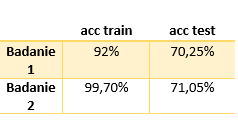

Uczenie kodera i modelu na całym zbiorze treningowym pozwoliło na uzyskanie lepszych wyników. Uzyskane w badaniu 2 wyniki nie różnią się znacząco od wyników uzyskanych w badaniu 1. Przy czym badanie 1 wykonuje się dużo krócej niż badanie 2. 

## Koder wykorzystujący sieci konwolucyjne

Zbadano jakość klasyfikacji wykorzystując koder zbudowany z wykorzystaniem  sieci konwolucyjnych. Przeprowadzono badania analogiczne jak w przypadku poprzedniego kodera. Zbadano czy większy wpływ na dokładność klasyfikacji ma to czy koder jest dobrze dopasowany do próbek czy to, że jest on uczony na większej ilości danych. W tym celu najpierw przeprowadzono badania, gdzie koder był trenowany na 10 obrazach a następnie model do klasyfikacji uczono na całym zbiorze treningowym.  W drugim badaniu zarówno koder jak i model uczono na całym zbiorze treningowym.


In [52]:
class CNNEncoder(torch.nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self._layers = torch.nn.Sequential(
            # Convolution
            torch.nn.Conv2d(3, 8, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(64, 96, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            # Invariant pooling
            torch.nn.MaxPool2d(kernel_size=3),
            # Flattening
            torch.nn.Flatten(),
            # MLP
            torch.nn.Linear(96, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, latent_dim),
        )

    def forward(self, img):
        return self._layers(img)

In [53]:
class CNNAutoencoder(Autoencoder):

    def __init__(self, latent_dim: int):
        super().__init__(
            encoder=CNNEncoder(latent_dim=latent_dim),
            decoder=CNNDecoder(latent_dim=latent_dim),
        )

### **Badanie 1:** Koder uczony na 10 obrazach, model do klasyfikacji uczony na całym zbiorze

In [54]:
conv_ae = CNNAutoencoder(latent_dim=64)
trainer = Trainer(
    accelerator="gpu",
    max_epochs=5000,
)

train_dl = DataLoader(train_data[:10], batch_size = 64, shuffle = True)
test_dl = DataLoader(test_data, batch_size = 128, shuffle = True)
trainer.fit(
    model=conv_ae,
    train_dataloaders=train_dl,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | _encoder | CNNEncoder | 100 K 
1 | _decoder | CNNDecoder | 199 K 
----------------------------------------
300 K     Trainable params
0         Non-trainable params
300 K     Total params
1.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5000` reached.


In [55]:
class ClassificationCNNEncoder(torch.nn.Module):
    
    def __init__(self, latent_dim: int, N: int):
        super().__init__()
        self.gce = conv_ae._encoder
        for param in self.gce.parameters():
          param.requires_grad = True;
        self.mlp=torch.nn.Sequential(
          torch.nn.ReLU(),
          torch.nn.Linear(64, 32),
          torch.nn.ReLU(),
          torch.nn.Linear(32, 1),
          torch.nn.Sigmoid()
        )
        self.float()

    def forward(self, img: torch.Tensor) -> torch.Tensor:
      x = self.gce(img)
      x = self.mlp(x)
      return x 

In [59]:
model = ClassificationCNNEncoder(latent_dim=64, N=8)
loss_fc = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_dl = DataLoader(train_data, batch_size = 128, shuffle = True)

for epoch in range(10):  
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        labels = labels.to(torch.float)
        optimizer.zero_grad()

        preds = model(inputs)
        loss = loss_fc(preds.reshape(preds.shape[0]), labels)

        loss.backward()
        optimizer.step()

        accuracy = torchmetrics.Accuracy(task='binary')
        acc = accuracy(preds.reshape(preds.shape[0]), labels)

        # print statistics
        running_loss += loss
        running_acc += acc

    print(
         f"Epoch {epoch}: "
         f"train loss = {running_loss / 8:.3f} (acc: {running_acc /8:.3f}), "
        )

Epoch 0: train loss = 0.694 (acc: 0.520), 
Epoch 1: train loss = 0.692 (acc: 0.520), 
Epoch 2: train loss = 0.692 (acc: 0.518), 
Epoch 3: train loss = 0.692 (acc: 0.519), 
Epoch 4: train loss = 0.692 (acc: 0.520), 
Epoch 5: train loss = 0.692 (acc: 0.519), 
Epoch 6: train loss = 0.692 (acc: 0.519), 
Epoch 7: train loss = 0.691 (acc: 0.573), 
Epoch 8: train loss = 0.691 (acc: 0.524), 
Epoch 9: train loss = 0.691 (acc: 0.522), 


In [60]:
total = 0
acc = 0

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images)
        total += 1
        accuracy = torchmetrics.Accuracy(task='binary')
        acc += accuracy(outputs.reshape(outputs.shape[0]), labels)

print(f'Zbiór testowy: accuracy =  {100 * acc / total} %')

Zbiór testowy: accuracy =  52.08082962036133 %


### **Badanie 2:** Zarówno koder jak i model do klasyfikacji trenowane na całym zbiorze

In [61]:
conv_ae = CNNAutoencoder(latent_dim=64)
trainer = Trainer(
    accelerator="gpu",
    max_epochs=5000,
)

train_dl = DataLoader(train_data, batch_size = 128, shuffle = True)
test_dl = DataLoader(test_data, batch_size = 128, shuffle = True)
trainer.fit(
    model=conv_ae,
    train_dataloaders=train_dl,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | _encoder | CNNEncoder | 100 K 
1 | _decoder | CNNDecoder | 199 K 
----------------------------------------
300 K     Trainable params
0         Non-trainable params
300 K     Total params
1.201     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5000` reached.


In [63]:
model = ClassificationCNNEncoder(latent_dim=64, N=8)
loss_fc = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_dl = DataLoader(train_data, batch_size = 128, shuffle = True)

for epoch in range(10):  
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        labels = labels.to(torch.float)
        optimizer.zero_grad()

        preds = model(inputs)
        loss = loss_fc(preds.reshape(preds.shape[0]), labels)

        loss.backward()
        optimizer.step()

        accuracy = torchmetrics.Accuracy(task='binary')
        acc = accuracy(preds.reshape(preds.shape[0]), labels)

        # print statistics
        running_loss += loss
        running_acc += acc

    print(
         f"Epoch {epoch}: "
         f"train loss = {running_loss / 8:.3f} (acc: {running_acc /8:.3f}), "
        )

Epoch 0: train loss = 0.625 (acc: 0.691), 
Epoch 1: train loss = 0.535 (acc: 0.753), 
Epoch 2: train loss = 0.494 (acc: 0.775), 
Epoch 3: train loss = 0.487 (acc: 0.778), 
Epoch 4: train loss = 0.449 (acc: 0.811), 
Epoch 5: train loss = 0.422 (acc: 0.815), 
Epoch 6: train loss = 0.401 (acc: 0.842), 
Epoch 7: train loss = 0.374 (acc: 0.854), 
Epoch 8: train loss = 0.355 (acc: 0.862), 
Epoch 9: train loss = 0.325 (acc: 0.875), 


In [64]:
total = 0
acc = 0

with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images)
        total += 1
        accuracy = torchmetrics.Accuracy(task='binary')
        acc += accuracy(outputs.reshape(outputs.shape[0]), labels)

print(f'Zbiór testowy: accuracy =  {100 * acc / total} %')

Zbiór testowy: accuracy =  70.19981384277344 %


### Podsumowanie badań

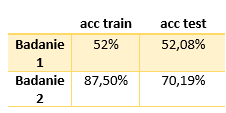

Trenowanie kodera jak i modelu na całym zbiorze treningowym pozwoliło na uzyskanie znacząco lepszych wyników, niż uczenie kodera na 10 obrazach. 

## Podsumowanie

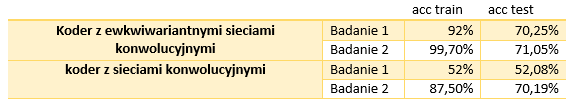

Potwierdziła się hipoteza badawcza. Zastosowanie ekwiwariantnych sieci konwolucyjnych jako kodera pozwoliło na otrzymanie lepszych wyników niż zastosowanie sieci konwolucyjnej w jako kodera.Szczególnie interesujące są wyniki dla Badania 1. Jego przeprowadzenie nie jest kosztowne czasowo, a w przypadku sieci ekwiwariantnych pozwala na uzyskanie bardzo dobrych wyników. Uzyskane rezulaty są gorsze niż wyniki autorów publikacji "*Rotation Equivariant CNNs for Digital
Pathology*". 

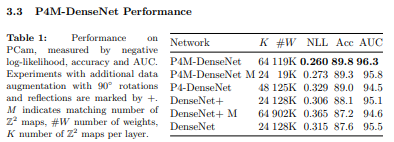

Różnica w uzyskanych wynikach może wynikać z faktu, że w ramach projektu zostosowano inną architekturę niż autorzy publikacji oraz użyto tylko 1000 obrazów ze zbioru treningowego oraz 1000 obrazów z zbioru testowego. 